In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [19]:
# Load the dataset
data = pd.read_csv('medium_data.csv')

In [20]:
# Inspect the dataset
data.head()

,id,url,title,subtitle,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...,Part 1: The Risks and Ethical Issues…,453.0,11,9,Towards Data Science,27-01-2023
1,2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...,An alternative approach to understanding bias ...,311.0,3,12,Towards Data Science,27-01-2023
2,3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru...",NaN,188.0,0,24,Towards Data Science,27-01-2023
3,4,https://towardsdatascience.com/dates-and-subqu...,Dates and Subqueries in SQL,Working with dates in SQL,15.0,1,4,Towards Data Science,27-01-2023
4,5,https://towardsdatascience.com/temporal-differ...,Temporal Differences with Python: First Sample...,NaN,10.0,0,13,Towards Data Science,27-01-2023


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2498 non-null   int64  
 1   url           2498 non-null   object 
 2   title         2498 non-null   object 
 3   subtitle      2073 non-null   object 
 4   claps         2423 non-null   float64
 5   responses     2498 non-null   int64  
 6   reading_time  2498 non-null   int64  
 7   publication   2498 non-null   object 
 8   date          2498 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 175.8+ KB


In [22]:
# Select features and target
features = ['responses', 'reading_time', 'publication']
target = 'claps'

# Handle missing values
data = data[features + [target]].dropna()

# Apply log transformation to target to handle skewness
y = np.log1p(data[target].values)

# Separate numerical and categorical columns
numerical_features = ['responses', 'reading_time']
categorical_features = ['publication']

# One-hot encode categorical feature
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(data[categorical_features])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

# Combine numerical and encoded categorical features
X = pd.concat([data[numerical_features].reset_index(drop=True), encoded_cats_df.reset_index(drop=True)], axis=1)

In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features after splitting to avoid data leakage
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1938, 6)
Testing set shape: (485, 6)


In [24]:
# Define the Keras model with regularization
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 21.1390 - mae: 4.2931 - val_loss: 8.4342 - val_mae: 2.5679
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9157 - mae: 1.9501 - val_loss: 3.0578 - val_mae: 1.1696
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0638 - mae: 1.3209 - val_loss: 2.2983 - val_mae: 1.0046
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9957 - mae: 1.2223 - val_loss: 1.9593 - val_mae: 0.9154
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3115 - mae: 1.0574 - val_loss: 1.7480 - val_mae: 0.8335
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3511 - mae: 1.0719 - val_loss: 1.5494 - val_mae: 0.7885
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1312 - mae: 1.0130 - val_loss: 1.4383 - val_mae: 0.7656
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2394 - mae: 1.0682 - val_loss: 1.3463 - val_mae: 0.7356
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0335 - mae

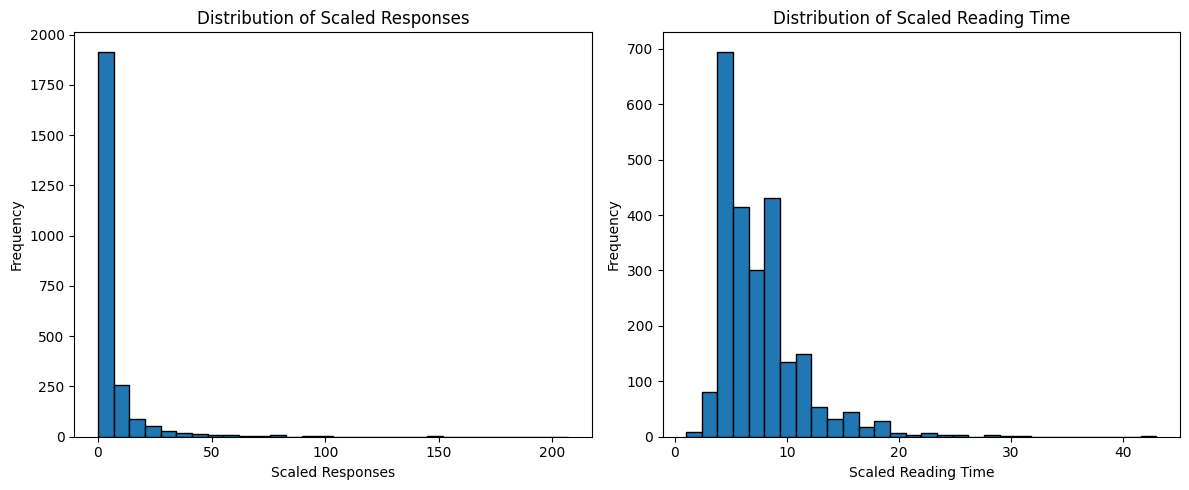

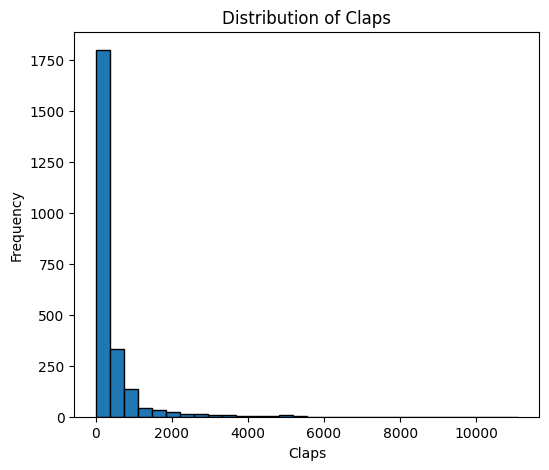

In [26]:
# Plot histograms for scaled numerical features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X['responses'], bins=30, edgecolor='black')
plt.title('Distribution of Scaled Responses')
plt.xlabel('Scaled Responses')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(X['reading_time'], bins=30, edgecolor='black')
plt.title('Distribution of Scaled Reading Time')
plt.xlabel('Scaled Reading Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot histogram for original claps (before log transformation)
plt.figure(figsize=(6, 5))
plt.hist(data[target], bins=30, edgecolor='black')
plt.title('Distribution of Claps')
plt.xlabel('Claps')
plt.ylabel('Frequency')
plt.show()

Test Loss (MSE, log-scale): 0.9086
Test MAE (log-scale): 0.6496
R² Score (original scale): 0.49


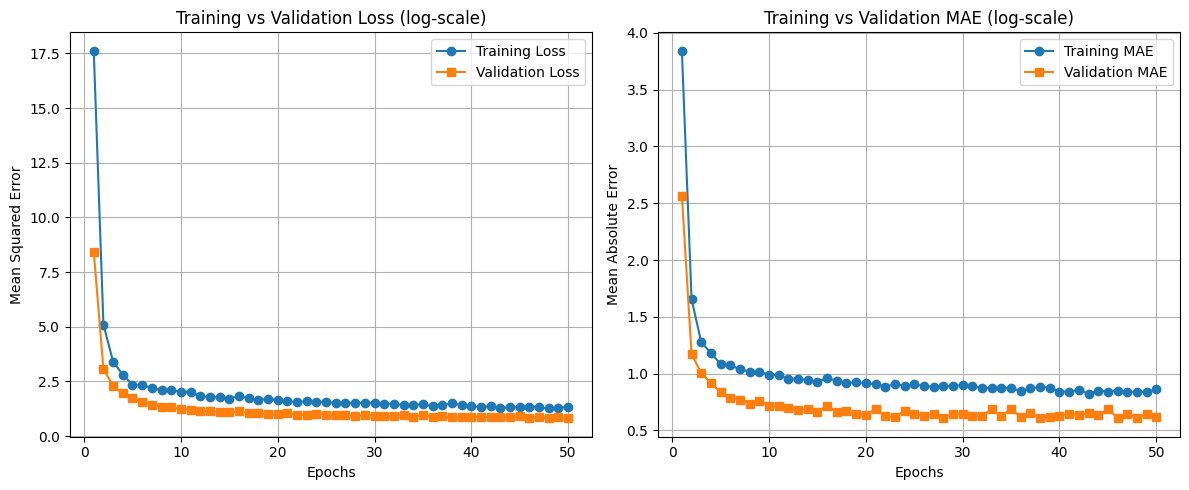

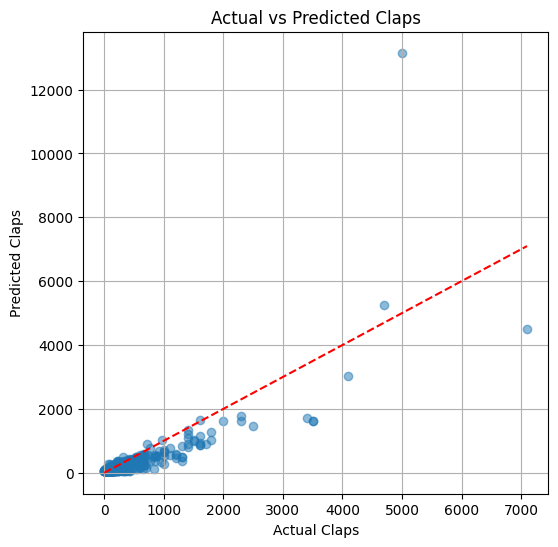

In [27]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predictions = np.expm1(predictions)  # Reverse log transformation
y_test_orig = np.expm1(y_test)  # Reverse log transformation for evaluation
r2 = r2_score(y_test_orig, predictions)
print(f"Test Loss (MSE, log-scale): {loss:.4f}")
print(f"Test MAE (log-scale): {mae:.4f}")
print(f"R² Score (original scale): {r2:.2f}")

# Plot training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 's-', label='Validation Loss')
plt.title('Training vs Validation Loss (log-scale)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae, 'o-', label='Training MAE')
plt.plot(epochs, val_mae, 's-', label='Validation MAE')
plt.title('Training vs Validation MAE (log-scale)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot actual vs predicted (original scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_orig, predictions, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual Claps')
plt.ylabel('Predicted Claps')
plt.title('Actual vs Predicted Claps')
plt.grid(True)
plt.show()